# 第3.4章 解线性方程迭代法

In [1]:
from scipy.sparse import random
import matplotlib.pyplot as plt
import scipy
import numpy as np

### (1) 对于稀疏矩阵，直接的LU分解无法合理利用稀疏性质

In [2]:
np.random.seed(1)
n = 1000
A = random(n,n,0.02).toarray()
A += np.diag(2*np.sum(A, axis=1))
b = np.random.randn(n)
P, L, U = scipy.linalg.lu(A)

In [3]:
print("A矩阵的非零项比例为:{:.3f}\n".format(sum(sum(1.0*(A != 0)))/n**2))
print("L矩阵的非零项比例为:{:.3f}".format(sum(sum(1.0*(L != 0)))/n**2))
print("U矩阵的非零项比例为:{:.3f}".format(sum(sum(1.0*(U != 0)))/n**2))

A矩阵的非零项比例为:0.021

L矩阵的非零项比例为:0.410
U矩阵的非零项比例为:0.406


### (2) 课本内的三维的例子

In [4]:
def jacobi(A, b, max_iterations=100, tolerance=1e-6):
    """
        Jacobi 迭代法
    """
    n = len(b)
    x = np.random.randn(n)  # Initial guess
    err = np.zeros(max_iterations)
    
    for k in range(max_iterations):
        x_old = x.copy()
        for i in range(n):
            sigma = sum(A[i, j] * x_old[j] for j in range(n) if j != i)
            x[i] = (b[i] - sigma) / A[i, i]

        # Check convergence
        err[k] = np.linalg.norm(x - x_old, ord=np.inf)
        if  err[k] < tolerance:                
            print(f'Converged in {k + 1} iterations.')
            return x, err[0:k], k

    print(f'Warning: Did not converge after {max_iterations} iterations.')
    return x, err[0:k], k

def gauss_seidel(A, b, initial_guess=None, max_iterations=100, tolerance=1e-6):
    """
       Gauss-Seidel 迭代法 
    """
    n = len(b)
    x = initial_guess if initial_guess is not None else np.random.randn(n)
    err = np.zeros(max_iterations)
    
    for k in range(max_iterations):
        for i in range(n):
            x_old_item = x[i]
            sigma_forward = np.dot(A[i, :i], x[:i])  # Forward substitution
            sigma_backward = np.dot(A[i, (i+1):], x[(i+1):])  # Backward substitution
            x[i] = (b[i] - sigma_forward - sigma_backward) / A[i,i]
            
            # use inf-norm
            err[k] = np.maximum(err[k], np.abs(x[i] - x_old_item))
        
        # Check convergence 
        if err[k] < tolerance:
            print(f'Converged in {k + 1} iterations.')
            return x, err[0:k], k

    print(f'Warning: Did not converge after {max_iterations} iterations.')
    return x, err[0:k], k

def SOR(A, b, ω, initial_guess=None, max_iterations=100, tolerance=1e-6):
    """
        逐次超松弛迭代法
    """
    n = len(b)
    x = initial_guess if initial_guess is not None else np.random.randn(n)
    err = np.zeros(max_iterations)
    
    for k in range(max_iterations):
        for i in range(n):
            x_old_item = x[i]
            sigma_forward = np.dot(A[i, :i], x[:i])  # Forward substitution
            sigma_backward = np.dot(A[i, (i+1):], x[(i+1):])  # Backward substitution
            x[i] = (b[i] - sigma_forward - sigma_backward) / A[i,i] 
            x[i] = ω * x[i] + (1-ω)*x_old_item
            
            # use inf-norm
            err[k] = np.maximum(err[k], np.abs(x[i] - x_old_item))
        
        # Check convergence  
        if err[k] < tolerance:
            print(f'Converged in {k + 1} iterations.')
            return x, err[0:k], k

    print(f'Warning: Did not converge after {max_iterations} iterations.')
    return x, err[0:k], k

Converged in 13 iterations.
[2.99999782 2.00000464 1.00000492]
Converged in 7 iterations.
[3.0000029  1.99999831 0.99999897]


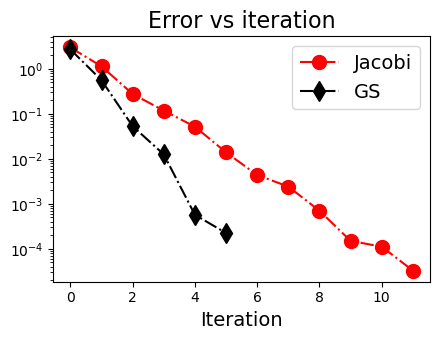

In [5]:
# 课本例题8.1

A = np.array([[8.0, -3, 2], [4, 11, -1], [6, 3, 12]])
b = np.array([20,33,36])

np.random.seed(1)
x_jac, err_jac, k_jac = jacobi(A.copy(), b.copy(), tolerance=1.0e-5)
print(x_jac)

np.random.seed(1)
x_gs, err_gs, k_gs = gauss_seidel(A.copy(), b.copy(), tolerance=1.0e-5)
print(x_gs)

plt.figure(figsize=(4.5,3.5))
plt.plot(range(k_jac), err_jac, 'ro-.', markersize=10.0, label="Jacobi")
plt.plot(range(k_gs),  err_gs,  'kd-.', markersize=10.0, label="GS")
plt.yscale("log")
plt.xlabel("Iteration", fontsize=14)
plt.title("Error vs iteration", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### (3) GS迭代法不一定比Jacobi迭代法好

Converged in 4 iterations.
[-3.  3.  1.]
[-1496.75502195  1594.55801409  -194.60598429]


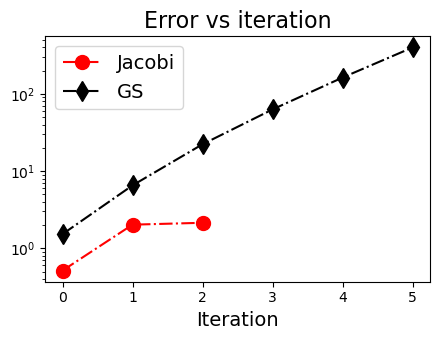

In [6]:
# 课本例题 8.3

A = np.array([[1.0, 2, -2], [1, 1, 1], [2, 2, 1]])
b = np.array([1, 1, 1])
x_true = np.linalg.solve(A, b)

np.random.seed(1)
x_jac, err_jac, k_jac = jacobi(A.copy(), b.copy(), tolerance=1.0e-5, max_iterations=7)
print(x_jac)

np.random.seed(1)
x_gs, err_gs, k_gs = gauss_seidel(A.copy(), b.copy(), tolerance=1.0e-5, max_iterations=7)
print(x_gs)

plt.figure(figsize=(4.5,3.5))
plt.plot(range(k_jac), err_jac, 'ro-.', markersize=10.0, label="Jacobi")
plt.plot(range(k_gs),  err_gs,  'kd-.', markersize=10.0, label="GS")
plt.yscale("log")
plt.xlabel("Iteration", fontsize=14)
plt.title("Error vs iteration", fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
print("Error of Jacobi = {:.3f}".format(np.linalg.norm(x_jac - x_true)))
print(x_jac)
print(x_true)

Error of Jacobi = 0.000
[-3.  3.  1.]
[-3.  3.  1.]


### (4) 高维问题

In [8]:
np.random.seed(4)
n = 100
A = random(n,n,0.1).toarray()
A += np.diag(1.3 * np.sum(A, axis=1))
b = np.random.randn(n)

Converged in 40 iterations.
Converged in 10 iterations.


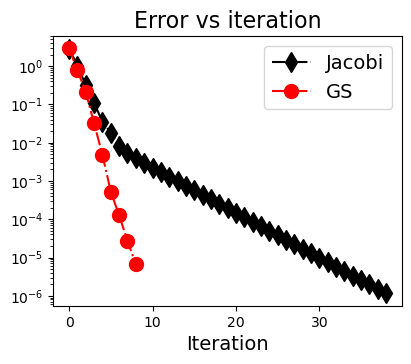

In [9]:
seed = 4

np.random.seed(seed)
x_jac, err_jac, k_jac = jacobi(A, b, tolerance=1.0e-6)
np.random.seed(seed)
x_gs,  err_gs,  k_gs  = gauss_seidel(A, b, tolerance=1.0e-6)

plt.figure(figsize=(4.5,3.5))
plt.plot(range(k_jac), err_jac, 'kd-.', markersize=10.0, label="Jacobi")
plt.plot(range(k_gs),  err_gs,  'ro-.', markersize=10.0, label="GS")
plt.yscale("log")
plt.xlabel("Iteration", fontsize=14)
plt.title("Error vs iteration", fontsize=16)
plt.legend(fontsize=14)
plt.show()

Converged in 23 iterations.
Converged in 15 iterations.
Converged in 10 iterations.
Converged in 19 iterations.
Converged in 58 iterations.


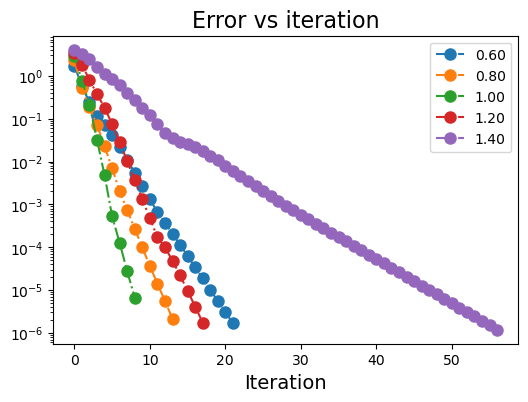

In [10]:
plt.figure(figsize=(6,4))
ω_list = [0.6, 0.8, 1.0, 1.2, 1.4]
for j in range(len(ω_list)):
    ω = ω_list[j]
    np.random.seed(seed)
    x_sor, err_sor, k_sor = SOR(A.copy(), b.copy(), ω)
    plt.plot(range(k_sor), err_sor, 'o-.', markersize=8.0, label="{:.2f}".format(ω))

plt.yscale("log")
plt.legend()
plt.xlabel("Iteration", fontsize=14)
plt.title("Error vs iteration", fontsize=16)
plt.show()

### (5) 对于$\omega$的优化

Converged in 60 iterations.
Converged in 39 iterations.
Converged in 26 iterations.
Converged in 21 iterations.
Converged in 15 iterations.
Converged in 16 iterations.
Converged in 21 iterations.


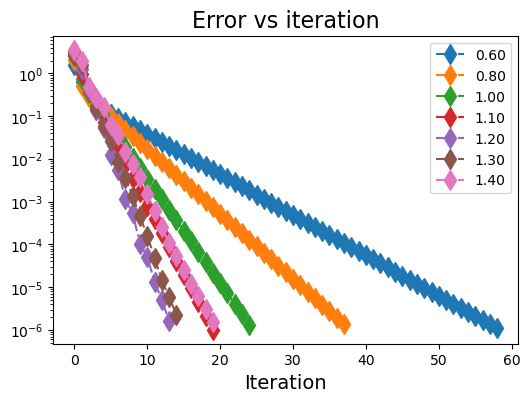

In [11]:
# 课本例子 8.11

seed = 5 
n = 4
A = np.array([[-4,1,1,1],[1,-4,1,1],[1,1,-4,1],[1,1,1,-4]])
b = np.array([1,1,1,1])

plt.figure(figsize=(6,4))
ω_list = [0.6, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4]
for j in range(len(ω_list)):
    ω = ω_list[j]
    np.random.seed(seed)
    x_sor, err_sor, k_sor = SOR(A.copy(), b.copy(), ω, tolerance=1e-6)
    plt.plot(range(k_sor), err_sor, 'd-.', markersize=10.0, label="{:.2f}".format(ω))

plt.yscale("log")
plt.legend()
plt.xlabel("Iteration", fontsize=14)
plt.title("Error vs iteration", fontsize=16)
plt.show()

In [12]:
from numpy import linalg as LA

B0 = np.identity(n)- np.matmul(np.linalg.inv(np.diag(np.diag(A))), A)
value = LA.eigvals(B0)
rho = np.max(np.abs(value))
ω_best = 2/(1+np.sqrt(1-rho**2))
print("spectral radius = {:.2f}".format(rho))
print("best omega      = {:.2f}".format(ω_best))

spectral radius = 0.75
best omega      = 1.20


In [13]:
A = np.array([[-4,1,1,1],[1,-4,1,1],[1,1,-4,1],[1,1,1,-4]])
U = -np.array([[0,1,1,1],[0,0,1,1],[0,0,0,1],[0,0,0,0]])
L = -np.array([[0,0,0,0],[1,0,0,0],[1,1,0,0],[1,1,1,0]])
D = np.diag(np.diag(A))

ω = 1.1
Lomega = np.matmul(np.linalg.inv(D - ω * L), (1-ω) * D + ω * U)
spec_radius = np.max(np.abs(LA.eigvals(Lomega)))
print("omega = {:.2f} spec_radius = {:.2f}".format(ω, spec_radius))

ω = 1.2
Lomega = np.matmul(np.linalg.inv(D - ω * L), (1-ω) * D + ω * U)
spec_radius = np.max(np.abs(LA.eigvals(Lomega)))
print("omega = {:.2f} spec_radius = {:.2f}".format(ω, spec_radius))

ω = 1.3
Lomega = np.matmul(np.linalg.inv(D - ω * L), (1-ω) * D + ω * U)
spec_radius = np.max(np.abs(LA.eigvals(Lomega)))
print("omega = {:.2f} spec_radius = {:.2f}".format(ω, spec_radius))

omega = 1.10 spec_radius = 0.48
omega = 1.20 spec_radius = 0.33
omega = 1.30 spec_radius = 0.37
